In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import umap
import scipy.io as sio
import hdbscan

In [2]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
# data_path = '/media/user/teamshare/nick/behavior/grooming/1p/GER2_ai94/20231116173257/GER2_ai94_20231116173257_svd.mat'
data_path = '/mnt/njm/nick/behavior/grooming/for_umap.mat'
mat_contents =  sio.loadmat(data_path)

In [4]:
mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Nov  5 10:55:41 2024',
 '__version__': '1.0',
 '__globals__': [],
 'behavior_label': array([[array(['Elliptical'], dtype='<U10')],
        [array(['Elliptical'], dtype='<U10')],
        [array(['Elliptical'], dtype='<U10')],
        ...,
        [array(['Right Asymmetric'], dtype='<U16')],
        [array(['Right Asymmetric'], dtype='<U16')],
        [array(['Right Asymmetric'], dtype='<U16')]], dtype=object),
 'feats': array([[-0.76344027, -0.4438759 ,  0.55513608, ...,  1.20873558,
          0.83313715,  1.20873558],
        [-0.62358323, -0.45031755,  0.47725323, ..., -0.75597878,
          0.49026567, -0.75597878],
        [-0.97322584, -0.72785025, -0.52722911, ...,  0.08421546,
          0.45078942,  0.08421546],
        ...,
        [-0.41379766,  2.90969818,  2.35233895, ...,  2.74685737,
          2.22760005,  2.74685737],
        [ 0.91484428,  3.12513236,  2.6133098 , ...,  1.55275654,
          0.836402

In [4]:
dat = np.dot(mat_contents['U'], np.dot(mat_contents['s'], mat_contents['V']))

In [7]:
# mat_contents['features'].shape
print(mat_contents['behavior_label'][0][0])
labels = [x[0][0] for x in mat_contents['behavior_label']]
print(labels)

['Elliptical']
['Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical Asymmetric', 'Elliptical Asymmetric', 'Elliptical Asymmetric', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Left', 'Left', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical', 'Elliptical

In [188]:
# reducer = umap.UMAP(min_dist=0.0, n_neighbors=40, metric='euclidean', n_components=2, verbose=True)
reducer = umap.UMAP(min_dist=0.1, n_components=2,n_neighbors=10,metric='correlation')


In [189]:
# reducer.fit(groom_frames.T)
dat = mat_contents['feats']
reducer.fit(dat)

UMAP(angular_rp_forest=True, metric='correlation', n_neighbors=10, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [161]:
UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

NameError: name 'UMAP' is not defined

In [190]:
# embedding = reducer.transform(dat.T)
embedding = reducer.transform(dat)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(4433, 2)

Text(0, 0.5, 'UMAP 2')

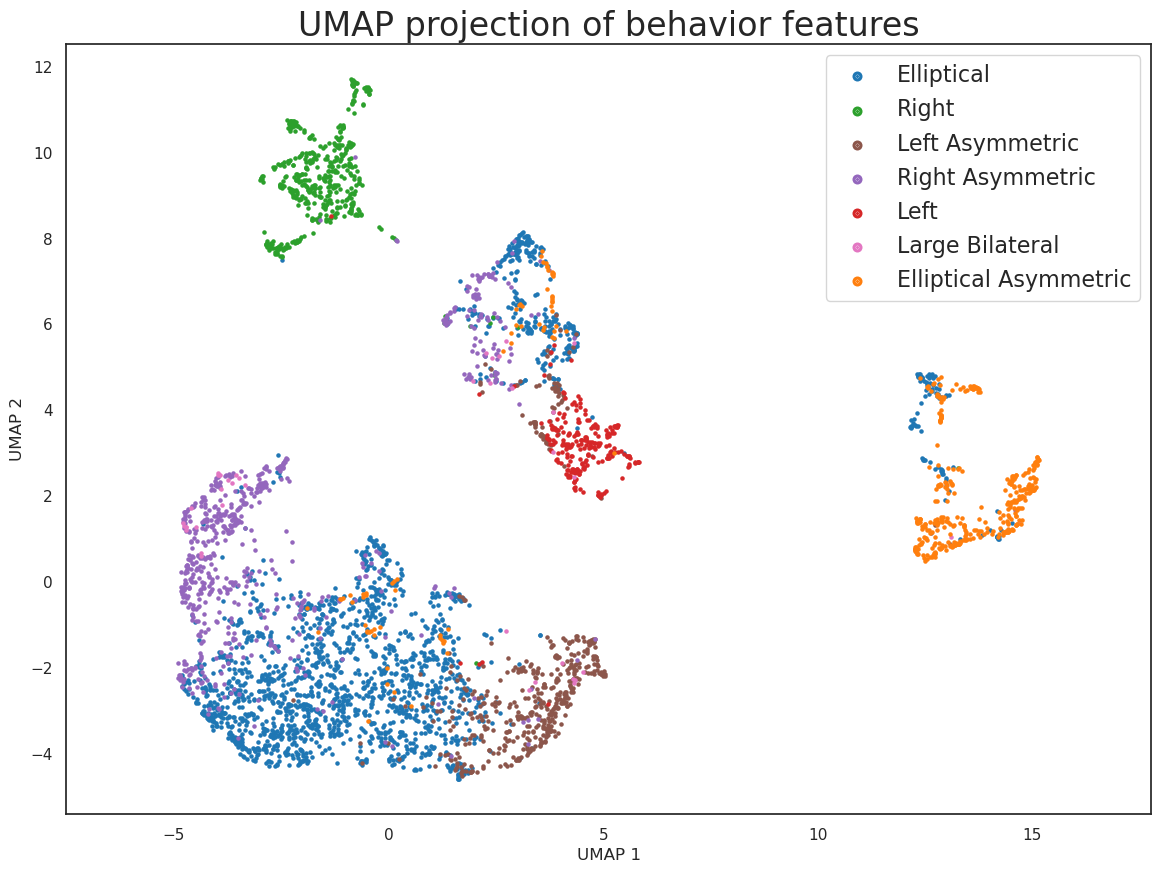

In [201]:
cols = []
for i,lab in enumerate(labels):
    if lab == "Elliptical":
        cols.append('#1f77b4')
    elif lab == "Elliptical Asymmetric":
        cols.append('#ff7f0e')
    elif lab == "Right":
        cols.append('#2ca02c')
    elif lab == "Left":
        cols.append('#d62728')
    elif lab == "Right Asymmetric":
        cols.append('#9467bd')
    elif lab == "Left Asymmetric":
        cols.append('#8c564b')
    elif lab == "Large Bilateral":
        cols.append('#e377c2')



fig = plt.figure()
ax = fig.add_subplot()
for ii, col in enumerate(np.unique(cols)):
    idx = [True if test[ii] == i else False for i in cols]
    ax.scatter(embedding[idx,0], embedding[idx,1], c=col, s=5)


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of behavior features', fontsize=24);
leg = plt.legend(["Elliptical", "Right", "Left Asymmetric", "Right Asymmetric", "Left", "Large Bilateral", "Elliptical Asymmetric"],prop={'size': 16})
for legobj in leg.legend_handles:
    legobj.set_linewidth(5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')



In [202]:
import sklearn.datasets
import sklearn.neighbors



In [181]:
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.1).fit_predict(reducer.embedding_)

In [182]:
outlying_digits = dat[outlier_scores == -1]
outlying_digits.shape

(444, 18)

In [281]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
def iterative_pruning(X, labels, min_score_threshold=0.0, max_iters=10):
    """
    Iteratively prunes outliers in a 2D dataset (e.g., UMAP) based on silhouette scores.
    
    Parameters:
    - X: numpy array, shape (n_samples, 2)  # 2D UMAP data
    - labels: initial cluster labels for the data
    - min_score_threshold: float, minimum silhouette score threshold for pruning
    - max_iters: int, maximum number of pruning iterations

    Returns:
    - X_pruned: pruned data points
    - final_labels: cluster labels after pruning
    - silhouette_history: list of silhouette scores for each iteration
    """

    silhouette_history = []
    X_pruned = X.copy()
    labels_pruned = np.array(labels.copy())
    # labels_pruned = convert_strings_to_numbers(labels_pruned)

    for i in range(max_iters):
        # Calculate silhouette scores for each point
        silhouette_vals = silhouette_samples(X_pruned, labels_pruned)
        overall_silhouette = silhouette_score(X_pruned, labels_pruned)
        silhouette_history.append(overall_silhouette)

        # Identify points below the threshold to consider as outliers
        outliers = silhouette_vals < min_score_threshold
        # print(sum(outliers))
        if not np.any(outliers):
            print("No more points below threshold; stopping.")
            break

        # Remove outliers from the dataset
        X_pruned = X_pruned[~outliers]
        labels_pruned = labels_pruned[~outliers]
        
        # # Re-cluster remaining points
        # n_clusters = len(np.unique(labels_pruned))
        # kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        # labels_pruned = kmeans.fit_predict(X_pruned)

        # Calculate new silhouette score
        new_silhouette_score = silhouette_score(X_pruned, labels_pruned)
        print(f"Iteration {i+1}: Silhouette Score = {new_silhouette_score}")

        # Check for improvement
        if i > 0 and silhouette_history[-1] <= silhouette_history[-2]:
            print("Silhouette score did not improve; stopping.")
            break

    return X_pruned, labels_pruned, silhouette_history

# Example usage:
# Assuming `X_umap` is your 2D UMAP data and `initial_labels` are initial cluster labels
# X_umap, initial_labels = some_umap_and_clustering_function()
# X_pruned, final_labels, silhouette_history = iterative_pruning(X_umap, initial_labels)

from collections import OrderedDict

def convert_strings_to_numbers(A):
    # Create an OrderedDict to maintain the order of first appearance
    unique_strings = OrderedDict()
    
    # Assign a unique integer to each unique string in the order of appearance
    for string in A:
        if string not in unique_strings:
            unique_strings[string] = len(unique_strings) + 1
    
    # Convert each string in A to its corresponding integer
    numeric_list = [unique_strings[string] for string in A]
    
    return numeric_list

In [291]:
X_pruned, labels_pruned, silhouette_history = iterative_pruning(embedding, labels, min_score_threshold=0.0, max_iters=10)

Iteration 1: Silhouette Score = 0.6383921504020691
Iteration 2: Silhouette Score = 0.6668722629547119
Iteration 3: Silhouette Score = 0.6695945262908936
Iteration 4: Silhouette Score = 0.6699786186218262
Iteration 5: Silhouette Score = 0.6703705787658691
No more points below threshold; stopping.


In [294]:
print(X_pruned.shape)
print(labels_pruned.shape)
print(np.unique(labels_pruned))

(2744, 2)
(2744,)
['Elliptical' 'Elliptical Asymmetric' 'Left' 'Left Asymmetric' 'Right'
 'Right Asymmetric']


Text(0, 0.5, 'UMAP 2')

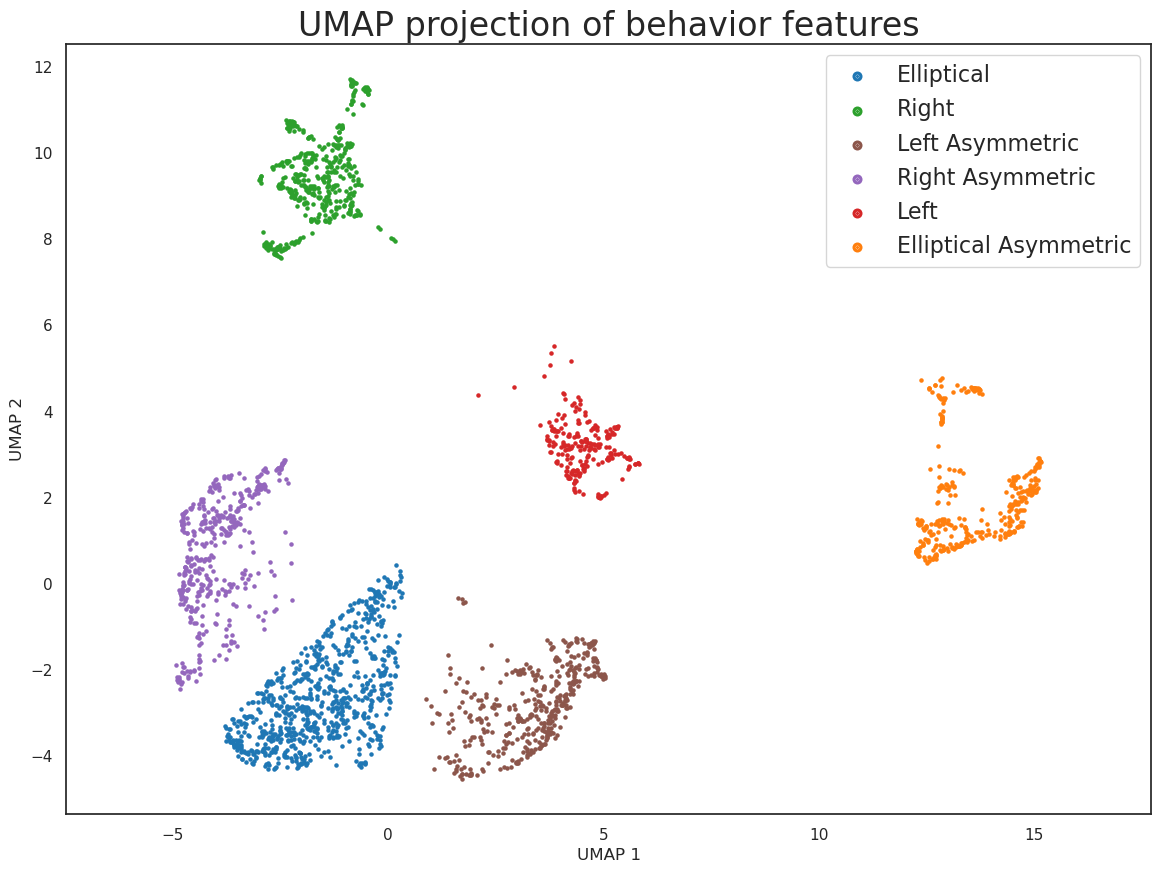

In [295]:
cols = []
for i,lab in enumerate(labels_pruned):
    if lab == "Elliptical":
        cols.append('#1f77b4')
    elif lab == "Elliptical Asymmetric":
        cols.append('#ff7f0e')
    elif lab == "Right":
        cols.append('#2ca02c')
    elif lab == "Left":
        cols.append('#d62728')
    elif lab == "Right Asymmetric":
        cols.append('#9467bd')
    elif lab == "Left Asymmetric":
        cols.append('#8c564b')
    elif lab == "Large Bilateral":
        cols.append('#e377c2')



fig = plt.figure()
ax = fig.add_subplot()
test = np.unique(cols)
for ii, col in enumerate(np.unique(cols)):
    idx = [True if test[ii] == i else False for i in cols]
    ax.scatter(X_pruned[idx,0], X_pruned[idx,1], c=col, s=5)


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of behavior features', fontsize=24);
leg = plt.legend(["Elliptical", "Right", "Left Asymmetric", "Right Asymmetric", "Left", "Elliptical Asymmetric"],prop={'size': 16})
for legobj in leg.legend_handles:
    legobj.set_linewidth(5)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')


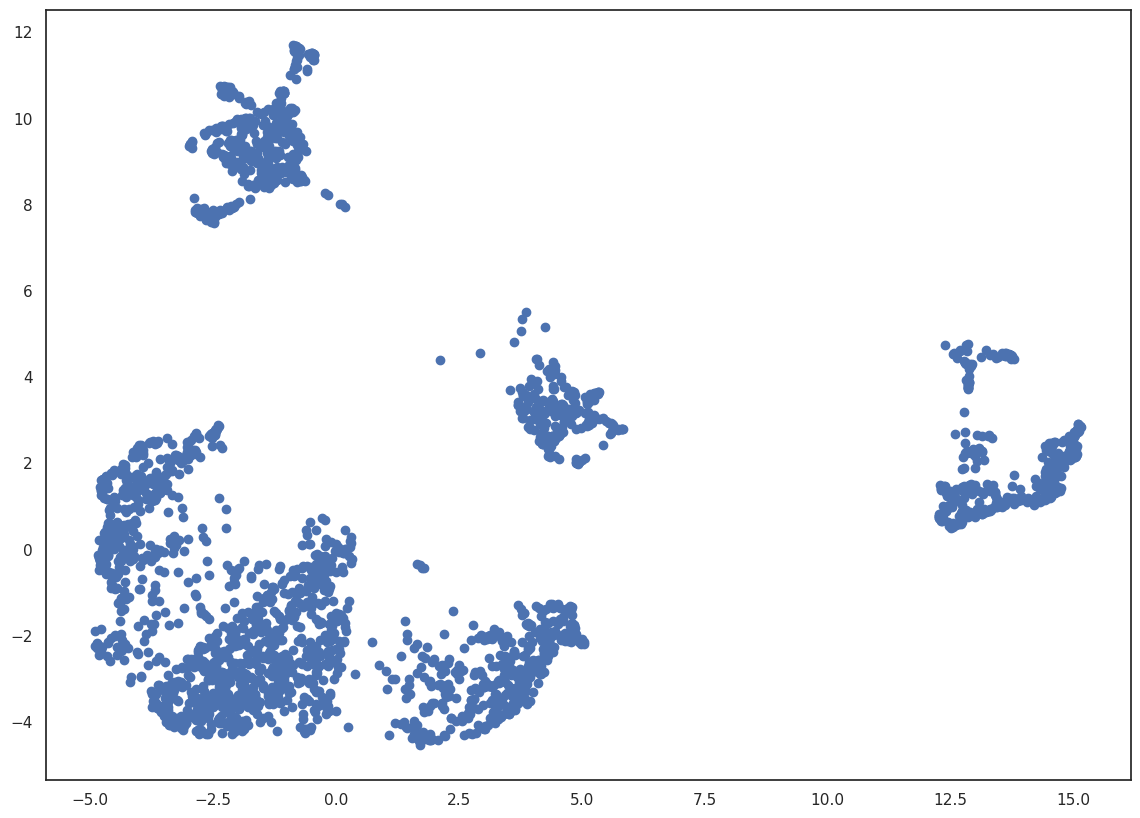